In [2]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transformC
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
#imageio.plugins.ffmpeg.download()

## Frist loading some images 

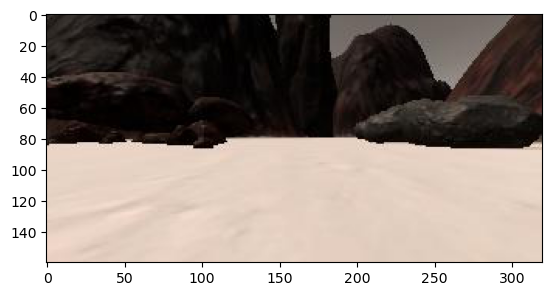

In [122]:
path = '../images_of_interest/*'
Img_list = glob.glob(path)
Img_list


image = mpimg.imread(Img_list[5])
plt.imshow(image)

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

(160, 320, 3)
(160, 320)


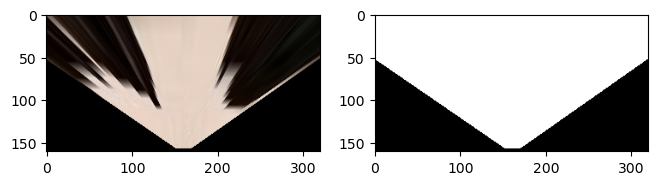

In [123]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))  # keep same size as input image
    ''' To improve the mapping precision we create this mask so that after the perspective transform and color thresh
        we could deduce the obstacles by subtracting the threshed from this mask'''
    mask = cv2.warpPerspective(np.ones_like(img[:, :, 0]), M, (img.shape[1], img.shape[0]))

    return warped, mask

#There is a catch you need to choose the parameters such that you map 1 pixel to 1 meter in the world map

dst = 10
bottom_offset = 5
source = np.float32([[14, 140],
                     [300, 140],
                     [200, 95],
                     [120, 95]])

destination = np.float32([[image.shape[1] / 2 - dst, image.shape[0] - bottom_offset],
                          [image.shape[1] / 2 + dst, image.shape[0] - bottom_offset],
                          [image.shape[1] / 2 + dst, image.shape[0] - 2*dst - bottom_offset],
                          [image.shape[1] / 2 - dst, image.shape[0] - 2*dst - bottom_offset]])


warped , mask = perspect_transform(image, source, destination)
m, n = mask.shape
for i in range(0,m):
    for j in range(0,n):
        if mask[i,j] > 0:
            mask[i,j] =1
        else:
            mask[i,j] =0


print(warped.shape)
print(mask.shape)

fig = plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.imshow(warped)
plt.subplot(132)
plt.imshow(mask, cmap='gray')

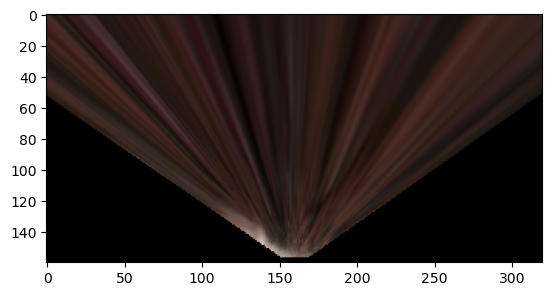

In [100]:
# Gaussian Blurring

blur = cv2.GaussianBlur(warped,(5,5),0)
blur = warped
'''
kernel = np.ones((5, 5), np.float32) / 25
blur = cv2.filter2D(warped, -1, kernel)
'''
plt.imshow(blur)

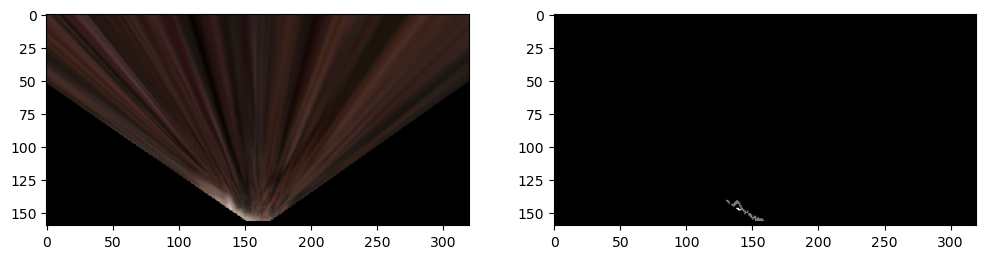

In [101]:
# Set high and low threshold
highThreshold = (180,180,160)
lowThreshold = (130,130,120)

M, N,_ = blur.shape
out = np.zeros_like(blur[:,:,0])

# strong ground pixels --> terrain for sure
strong_threshed = (blur[:,:,0] > highThreshold[0]) \
                & (blur[:,:,1] > highThreshold[1]) \
                & (blur[:,:,2] > highThreshold[2])

# obstacles
zero_threshed =   (blur[:,:,0] < lowThreshold[0]) \
                & (blur[:,:,1] < lowThreshold[1]) \
                & (blur[:,:,2] < lowThreshold[2])

# weak edges
weak_threshed = (blur[:,:,0]  > lowThreshold[0]) & (blur[:,:,0] < highThreshold[0]) \
                & (blur[:,:,1] > lowThreshold[1]) & (blur[:,:,1] < highThreshold[1]) \
                & (blur[:,:,2] > lowThreshold[2]) & (blur[:,:,2] < highThreshold[2]) 

# Set same intensity value for all edge pixels
out[strong_threshed] = 255
out[zero_threshed ] = 0
out[weak_threshed] = 127

fig = plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.imshow(blur)
plt.subplot(122)
plt.imshow(out, cmap='gray')

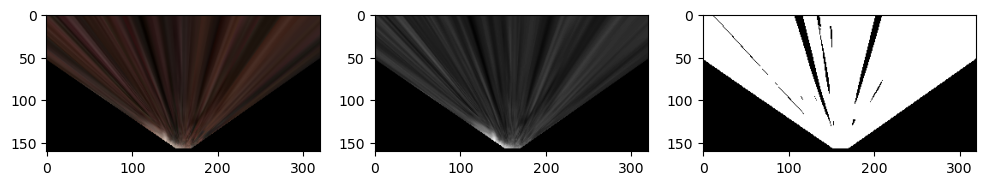

In [114]:
gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
otsu_threshold, otsu_threshed_image = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)

ig = plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.imshow(blur)
plt.subplot(132)
plt.imshow(gray, cmap='gray')
plt.subplot(133)
plt.imshow(otsu_threshed_image, cmap='gray')

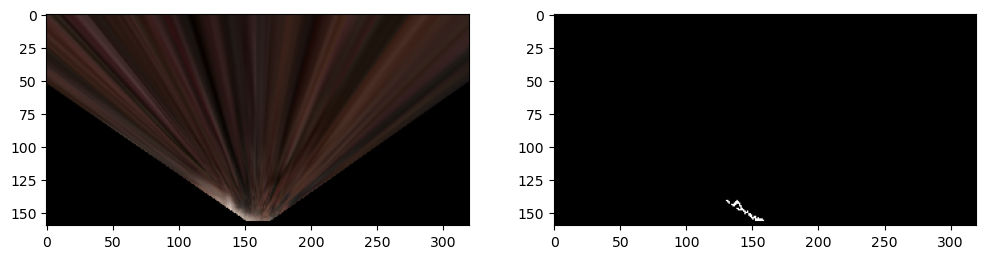

In [103]:
new = out*otsu_threshed_image
for i in range(0, M):
    for j in range(0, N):
        if (new[i,j] > 0):
            out[i,j] = 255
ig = plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.imshow(blur)
plt.subplot(122)
plt.imshow(out, cmap='gray')

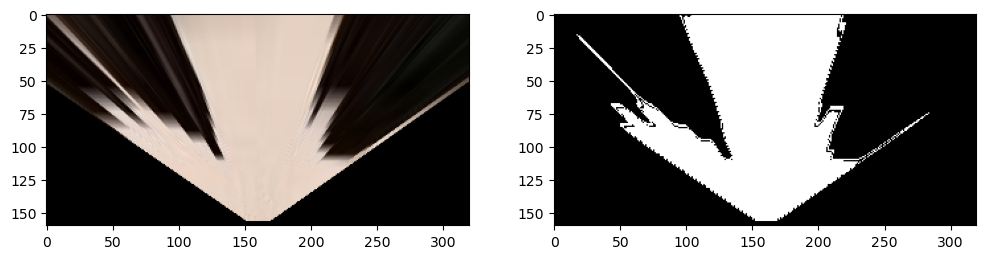

In [124]:
def new_thresholding(image,blur_kernel_size = (5,5), lower= (130,130,120) ,upper= (180,180,160)):
    # Gaussian Blurring
    blur = cv2.GaussianBlur(image,blur_kernel_size,0)
    
    # Apply part 1 of hystresis thresholding
    # Set high and low threshold
    highThreshold = upper
    lowThreshold = lower

    M, N,_ = blur.shape
    out = np.zeros_like(blur[:,:,0])

    # strong ground pixels --> terrain for sure
    strong_threshed = (blur[:,:,0] > highThreshold[0]) \
                & (blur[:,:,1] > highThreshold[1]) \
                & (blur[:,:,2] > highThreshold[2])

    # obstacles
    zero_threshed =   (blur[:,:,0] < lowThreshold[0]) \
                & (blur[:,:,1] < lowThreshold[1]) \
                & (blur[:,:,2] < lowThreshold[2])

    # weak edges
    weak_threshed = (blur[:,:,0]  > lowThreshold[0]) & (blur[:,:,0] < highThreshold[0]) \
                & (blur[:,:,1] > lowThreshold[1]) & (blur[:,:,1] < highThreshold[1]) \
                & (blur[:,:,2] > lowThreshold[2]) & (blur[:,:,2] < highThreshold[2]) 

    # Set same intensity value for all edge pixels
    out[strong_threshed] = 255
    out[zero_threshed ] = 0
    out[weak_threshed] = 127
    
    
    # convert the coloured image to gray and apply otsu thresholding
    gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    otsu_threshold, otsu_threshed_image = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)

    
    # decision step of the weak pixels from hystresis
    new = out*otsu_threshed_image
    for i in range(0, M):
        for j in range(0, N):
            if (new[i,j] > 0):
                out[i,j] = 1
                
    return out

threshed = new_thresholding(warped)
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.imshow(warped)
plt.subplot(122)
plt.imshow(threshed, cmap='gray')